Code influenced from ==> "https://github.com/krishnaik06/Stock-MArket-Forecasting"

In [1]:
import pandas as pd
df=pd.read_csv('GOOG.csv')

In [2]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-08-31,271.352905,272.130005,266.999207,269.469971,269.469971,5406790
1,2011-09-01,269.365356,270.899597,264.618134,265.255768,265.255768,4849108
2,2011-09-02,261.255737,262.974304,259.392731,261.440063,261.440063,4820401
3,2011-09-06,254.446274,260.403931,254.296829,260.115021,260.115021,5451959
4,2011-09-07,264.234589,266.969330,262.715271,266.017914,266.017914,5532259


In [207]:
dfopen=df.reset_index()['Open']

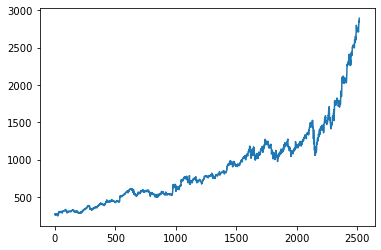

In [208]:
import matplotlib.pyplot as plt
plt.plot(dfopen)

In [209]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dfopen=scaler.fit_transform(np.array(dfopen).reshape(-1,1))
dfopen

array([[0.01028413],
       [0.00953411],
       [0.00647387],
       ...,
       [0.98425656],
       [0.98043763],
       [1.        ]])

In [210]:
training_size=int(len(dfopen)*0.65)
test_size=len(dfopen)-training_size
train_data,test_data=dfopen[0:training_size,:],dfopen[training_size:len(dfopen),:1]

In [211]:
training_size,test_size

(1635, 881)

In [212]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [213]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 200
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [214]:
print(X_train.shape), print(y_train.shape)

(1434, 200)
(1434,)


(None, None)

In [215]:
print(X_test.shape), print(ytest.shape)

(680, 200)
(680,)


(None, None)

In [216]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [217]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [218]:
model=Sequential()
model.add(LSTM(50,activation="relu",return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,activation="relu",return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [219]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 200, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 200, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [220]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 1434 samples, validate on 680 samples
Epoch 1/100
1434/1434 [==============================] - 16s 11ms/sample - loss: 0.0093 - val_loss: 0.0998
Epoch 2/100
1434/1434 [==============================] - 10s 7ms/sample - loss: 0.0015 - val_loss: 0.0591
Epoch 3/100
1434/1434 [==============================] - 10s 7ms/sample - loss: 2.0740e-04 - val_loss: 0.0090
Epoch 4/100
1434/1434 [==============================] - 10s 7ms/sample - loss: 1.0758e-04 - val_loss: 0.0047
Epoch 5/100
1434/1434 [==============================] - 11s 8ms/sample - loss: 9.4278e-05 - val_loss: 0.0036
Epoch 6/100
1434/1434 [==============================] - 12s 8ms/sample - loss: 9.9693e-05 - val_loss: 0.0037
Epoch 7/100
1434/1434 [==============================] - 11s 8ms/sample - loss: 9.4980e-05 - val_loss: 0.0038
Epoch 8/100
1434/1434 [==============================] - 10s 7ms/sample - loss: 9.5116e-05 - val_loss: 0.0036
Epoch 9/100
1434/1434 [==============================] - 9s 6ms/sample - loss: 1

In [221]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [222]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [223]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

671.2217882022321

In [224]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1625.2230717616137

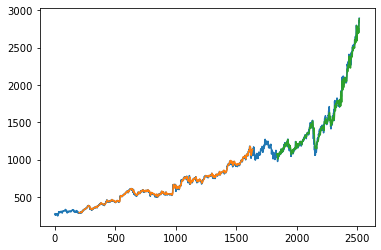

In [225]:
### Plotting 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dfopen)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dfopen)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(dfopen)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dfopen))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [226]:
len(test_data)

881

In [227]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 200)

In [228]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [229]:
temp_input

[0.5673719269033507,
 0.5711455259977437,
 0.5764549595461196,
 0.5784323216979824,
 0.5740134518754847,
 0.5638813477410373,
 0.5740058975074576,
 0.5681153149815088,
 0.5609077497678561,
 0.5769040419893865,
 0.5769794954806388,
 0.580033844323481,
 0.5774625271081585,
 0.5864172705893147,
 0.5961946786731238,
 0.5963871360005369,
 0.5943041017532339,
 0.5909455895025862,
 0.5916663597598523,
 0.575738012699456,
 0.5731946106834341,
 0.5777002657379048,
 0.573707814499873,
 0.576900264616693,
 0.5752512036992428,
 0.5698436528008137,
 0.5544964086800814,
 0.5623907945893876,
 0.5600058539238975,
 0.5626058693603329,
 0.5688832552274546,
 0.5825267136966699,
 0.5727983642878873,
 0.5627643771261334,
 0.5711115764361311,
 0.55883227026594,
 0.5503907309785824,
 0.5645153327663304,
 0.5825983898152287,
 0.5818776195579627,
 0.5697455354507603,
 0.5639568012322895,
 0.569632308987293,
 0.5638096252072096,
 0.5691153277981608,
 0.599005991507811,
 0.6241155345989383,
 0.6232400799864742,


In [230]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
i=0
days=30
while(iddays):
    
    x_input=np.array(temp_input[len(temp_input)-time_step:])
    print("{} day input {}".format(i+1,x_input))
    x_input = x_input.reshape((1, time_step, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i+1,yhat[0]))
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i=i+1
    1

print(lst_output)

 0.80213129 0.80163315 0.79492368 0.81355021 0.80407466 0.77274255
 0.76136509 0.76113118 0.77273122 0.77933124 0.78974107 0.76238017
 0.7863954  0.80071619 0.80109733 0.82109741 0.81839361 0.82748986
 0.82183702 0.82185213 0.82687481 0.81167096 0.82204836 0.83291635
 0.84370123 0.85109752 0.84902582 0.86068998 0.85633901 0.86277301
 0.86070131 0.85523337 0.85661079 0.85687115 0.86222964 0.86298436
 0.8667844  0.86605603 0.8663806  0.86466359 0.85621869 0.85015228
 0.86516929 0.88486745 0.89159581 0.87581459 0.88105608 0.88776555
 0.895675   0.9033732  0.90789019 0.90140717 0.89774302 0.88905241
 0.89496183 0.90902227 0.92872044 0.95128658 0.96457718 0.9536413
 0.93717787 0.93061479 0.93041478 0.93430538 0.9361884  0.9345205
 0.93653177 0.94146766 0.94999981 0.9515356  0.94723373 0.95209786
 0.94939978 0.95084132 0.9427243  0.93028653 0.94247896 0.95693564
 0.97614332 0.98625271 0.98425656 0.98043763 1.         0.97927034
 0.96243119 0.94562489 0.93250036 0.92496878 0.92331672 0.926842

In [231]:
day_real=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+1+days)

In [232]:
len(dfopen)


2516

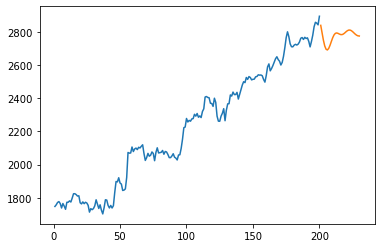

In [233]:
plt.plot(day_real,scaler.inverse_transform(dfopen[len(dfopen)-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))


In [234]:
print(scaler.inverse_transform(lst_output))

[[2839.15669293]
 [2794.53312219]
 [2749.99658284]
 [2715.21672092]
 [2695.25810019]
 [2690.88015251]
 [2700.22426006]
 [2719.13344959]
 [2742.42200836]
 [2764.68182762]
 [2781.53432787]
 [2791.00590245]
 [2793.39002563]
 [2790.95883284]
 [2786.75115711]
 [2783.59433414]
 [2783.40115919]
 [2786.76932156]
 [2792.96734684]
 [2800.30294038]
 [2806.7435795 ]
 [2810.55985088]
 [2810.78335256]
 [2807.38028286]
 [2801.15540578]
 [2793.46789583]
 [2785.86868088]
 [2779.74047025]
 [2776.00317473]
 [2774.96116726]]


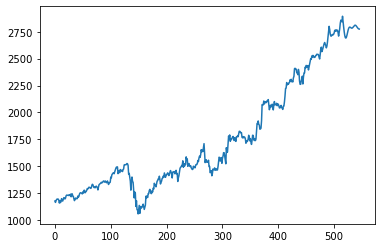

In [235]:
dfopenlist=dfopen.tolist()
dfopenlist.extend(lst_output)
plt.plot(scaler.inverse_transform(dfopenlist[2000:]))